# For Showcasing How the `pyStrGraph` Library Should Be Used
- DO compile the library first then run this notebook
- In the first cell, if the `pyStrGraph` library is not found, change the `sys.path.append` command to append the path of the library to the system path
- If anyting is not clear, try to find references in README.md in the root directory of the repository or reach me at chengxzhcuhk@gmail.com

In [1]:
import os, sys
sys.path.append("../build/src/") # add the route of the exported dynamic library
import pyStrGraph
import graphviz

## Example 1: Base example
1. Create a `pyStrGraph` object with the desired input string values; Input nodes containing the values are automatically created
    -  order is sensitive
3. Add operator nodes through the interface `pyStrGraph.DAG.addOperatorNode`.
    - accepts two arguments, first being the list of the parent nodes, second being the operator (a function accepts list of strings and return one string)
    - some operators only supports certain number of input strings, that number is checked in runtime. If not met, an `std::runtime_error` is thrown, but can cause `ipykernel` or `jupyter` to die
    - `addOperatorNode` returns the node id of the added Node for subsequent reference
4. Call `pyStrGraph.DAG.doCompute()` to do the computation;
    - accepts `use_multithread` as a bool and `verbose_level` as an integer
    - returns a list of str as the result

In [2]:
# define the topology of the DAG
dag = pyStrGraph.DAG( ["Hello", "World"] ) # The input nodes contain ["Hello", "World"], node ids are: [ 0, 1 ]
concated_node = dag.addOperatorNode([0, 1], pyStrGraph.ConcatOperator(" ")) # result: "Hello World"

res = dag.doCompute(use_multithread = False, verbose_level = 0 )
res[0]

'Hello World'

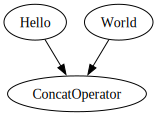

In [3]:
dot_graph = '''
digraph Example {
  Hello -> ConcatOperator;
  World -> ConcatOperator;
}
'''

graph = graphviz.Source(dot_graph); graph.format = 'svg'; graph.render(filename='graph', directory='.', cleanup=True)
graph

## Example 2: A Little More Complexity

In [4]:
# define the topology of the DAG
dag = pyStrGraph.DAG( ["Hello", "World", "Str", "Graph"] ) # The input nodes contain ["Hello", "World", "Str", "Graph"]
concated_node = dag.addOperatorNode([0, 1], pyStrGraph.ConcatOperator(" ")) # result: "Hello World"
repeated_node = dag.addOperatorNode([2], pyStrGraph.RepeatOperator(2, " | ")) # result: "Str | Str"
concated_node_1 = dag.addOperatorNode([concated_node, repeated_node, 3], pyStrGraph.ConcatOperator(" ")) # result: "Hello World Str | Str Graph"
final_id = dag.addOperatorNode([concated_node_1], pyStrGraph.InsertOperator(3, " <=> "))
# result: "Hel <=> lo  <=> Wor <=> ld  <=> Str <=>  |  <=> Str <=>  Gr <=> aph"

res = dag.doCompute(use_multithread = False, verbose_level = 0 )
res[0]

'Hel <=> lo  <=> Wor <=> ld  <=> Str <=>  |  <=> Str <=>  Gr <=> aph'

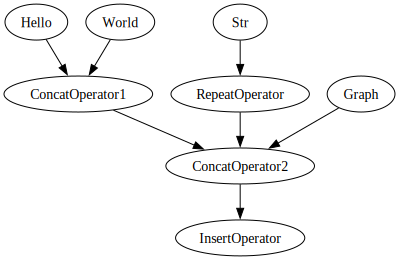

In [5]:
dot_graph = '''
digraph Example {
  Hello -> ConcatOperator1;
  World -> ConcatOperator1;
  Str -> RepeatOperator;
  ConcatOperator1 -> ConcatOperator2;
  RepeatOperator -> ConcatOperator2;
  "Graph" -> ConcatOperator2;
  ConcatOperator2 -> InsertOperator;
}
'''

graph = graphviz.Source(dot_graph); graph.format = 'svg'; graph.render(filename='graph', directory='.', cleanup=True)
graph

## Example 3: Define a `DAG` in One Call

- Use `<<` operator to add new nodes in the graph
  - `<<` expects a tuple/list of length 2, the first element is a list of parent node ids, the second is the operator
  - This makes the constructing of the graph composable and easier to understand

In [6]:
dag = ( pyStrGraph.DAG( ["Hello", "World", "Str", "Graph"] )
        << ([0, 1], pyStrGraph.ConcatOperator(" "))
        << ([4, 2], pyStrGraph.ConcatOperator(" "))
        << ([5, 3], pyStrGraph.ConcatOperator(" "))
)

res = dag.doCompute(use_multithread = False, verbose_level = 0 )
res[0]

'Hello World Str Graph'

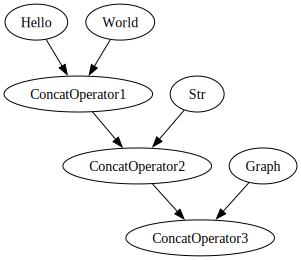

In [7]:
dot_graph = '''
digraph Example {
  Hello -> ConcatOperator1;
  World -> ConcatOperator1;
  ConcatOperator1 -> ConcatOperator2;
  Str -> ConcatOperator2;
  "Graph" -> ConcatOperator3;
  ConcatOperator2 -> ConcatOperator3;
}
'''

graph = graphviz.Source(dot_graph); graph.format = 'svg'; graph.render(filename='graph', directory='.', cleanup=True)
graph

## Example 4: Same as Example 3 But Using Python Operators Instead

In [8]:
pyDag = ( pyStrGraph.DAG( ["Hello", "World", "Str", "Graph"] )
        << ([0, 1], pyStrGraph.Operator(lambda str_list: " ".join(str_list)))
        << ([4, 2], pyStrGraph.Operator(lambda str_list: " ".join(str_list)))
        << ([5, 3], pyStrGraph.Operator(lambda str_list: " ".join(str_list)))
)

pyDag.doCompute(use_multithread = False, verbose_level = 0 ) == res

True

## Example 5: Performance Benchmarks
1. This example will use bigger input data and compare the performances of Python operators and predefined C++ operators
2. The performances between C++ single-thread and multi-thread will also be compared
3. On My machine, it looks like this (6 input nodes and 10 operator nodes):
    - elapsed time (Python Operator): 6.309930801391602 seconds
    - elapsed time (Cpp Operator, Single Threaded): 1.7017791271209717 seconds
    - elapsed time (Cpp Operator, Multi Threaded): 1.3639822006225586 seconds

In [9]:
## Preparation
import random
def generate_random_string(num_words):
    word_list = [
        "apple", "banana", "cat", "dog", "elephant", "fish", "gorilla",
        "house", "igloo", "jungle", "kangaroo", "lion", "monkey", "nest",
        "ocean", "penguin", "queen", "rabbit", "snake", "tiger", "umbrella",
        "violet", "whale", "xylophone", "yak", "zebra"
    ]
    random_string = ' '.join(random.choices(word_list, k=num_words))
    return random_string

test_str_list = [generate_random_string(1000000), generate_random_string(1000000),
                 generate_random_string(1000000), generate_random_string(1000000),
                 generate_random_string(1000000), generate_random_string(1000000)
                ]

pyConcatOperator = pyStrGraph.Operator( lambda list_str: " ".join(list_str) )
cppConcatOperator = pyStrGraph.ConcatOperator( " " )

pyRotateOperator = pyStrGraph.Operator( lambda list_str: list_str[0][150:] + list_str[0][:150] )
cppRotateOperator = pyStrGraph.RotateOperator( -150 )

def capitalize(text: str):
    result = ""
    capitalize = True

    for char in text:
        if char.isspace():
            capitalize = True
        elif capitalize:
            char = char.upper()
            capitalize = False
        result += char

    return result
pyCapitalizeOperator = pyStrGraph.Operator( lambda list_str: capitalize( list_str[0] ) )
cppCapitalizeOperator = pyStrGraph.CapitalizeOperator()

In [10]:
pyDag = ( pyStrGraph.DAG( test_str_list )
    << ( [0, 1], pyConcatOperator )
    << ( [2, 3], pyConcatOperator )
    << ( [4, 5], pyConcatOperator )
    << ( [6], pyRotateOperator )
    << ( [7], pyRotateOperator )
    << ( [8], pyRotateOperator )
    << ( [9], pyCapitalizeOperator )
    << ( [10], pyCapitalizeOperator )
    << ( [11], pyCapitalizeOperator )
    << ( [12, 13, 14], pyConcatOperator )
)

cppDag = ( pyStrGraph.DAG( test_str_list )
    << ( [0, 1], cppConcatOperator )
    << ( [2, 3], cppConcatOperator )
    << ( [4, 5], cppConcatOperator )
    << ( [6], cppRotateOperator )
    << ( [7], cppRotateOperator )
    << ( [8], cppRotateOperator )
    << ( [9], cppCapitalizeOperator )
    << ( [10], cppCapitalizeOperator )
    << ( [11], cppCapitalizeOperator )
    << ( [12, 13, 14], cppConcatOperator )
)

In [11]:
import time
pyDag.touch() ## markDirty
start_time = time.time()
pyRes = pyDag.doCompute(use_multithread = False, verbose_level = 0 )
end_time = time.time()
print(f"elapsed time (Python Operator): {end_time - start_time} seconds")

cppDag.touch() ## markDirty
start_time = time.time()
cppResSingleThread = cppDag.doCompute(use_multithread = False, verbose_level = 0 )
end_time = time.time()
print(f"elapsed time (Cpp Operator, Single Threaded): {end_time - start_time} seconds")

cppDag.touch() ## markDirty
start_time = time.time()
cppResMultiThread = cppDag.doCompute(use_multithread = True, verbose_level = 0 )
end_time = time.time()
print(f"elapsed time (Cpp Operator, Multi Threaded): {end_time - start_time} seconds")

elapsed time (Python Operator): 6.342487096786499 seconds
elapsed time (Cpp Operator, Single Threaded): 1.4594197273254395 seconds
elapsed time (Cpp Operator, Multi Threaded): 1.2701466083526611 seconds


In [12]:
print(pyRes == cppResSingleThread)
print(pyRes == cppResMultiThread)

True
True
